<a href="https://colab.research.google.com/github/FrancescoMonaco/LFN_Project/blob/francesco_branch/LFN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations, Imports, Data Retrieval
gt : graph-tool\
nx : networkx\
go: plotly


In [ ]:
%%capture
! sudo apt-get install python3.7
! sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
! sudo update-alternatives --config python3
! sudo apt install python3-pip
! sudo apt install python3.7-distutils
! python -m pip install snap-stanford
!pip install nilearn
!pip install plotly
!pip install graph-tool
import sys
sys.path.append("/usr/local/lib/python3.7/dist-packages/")

In [ ]:
#@title Imports
#*** Libraries to manipulate fMRI data
from nilearn import datasets, plotting
from nilearn.maskers import NiftiMapsMasker, NiftiSpheresMasker
#*** Libraries for graphs
import networkx as nx
import snap
#from graph_tool.all import *
#*** Basic imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd
import gc, os
from tqdm import tqdm
#*** Scaler for the data
from sklearn.preprocessing import StandardScaler



In [ ]:
#@title Data download
%%capture
# Load the brain atlas
atlas = datasets.fetch_atlas_msdl()
# Load the atlas image stored in 'maps'
atlas_filename = atlas["maps"]
# Load atlas data stored in 'labels'
labels = atlas["labels"]

# Load the dataset
_, urls = datasets.fetch_ds000030_urls()

selected_subjects = [
    'sub-10159', 'sub-10171', 'sub-10189', 'sub-10206', 'sub-10217',
    'sub-10292', 'sub-10524', 'sub-10316', 'sub-10940', 'sub-11156',
    'sub-50004', 'sub-50005', 'sub-50006', 'sub-50007', 'sub-50008',
    'sub-50010', 'sub-50013', 'sub-50014', 'sub-50015', 'sub-50016',
    'sub-60001', 'sub-60005', 'sub-60006', 'sub-60008', 'sub-60010',
    'sub-60011', 'sub-60012', 'sub-60014', 'sub-60015', 'sub-60016',
    'sub-70017', 'sub-70020', 'sub-70021', 'sub-70022', 'sub-70026',
    'sub-70029', 'sub-70033', 'sub-70034', 'sub-70083', 'sub-70086'
]

filtered_urls = [url for url in urls if any(subject in url for subject in selected_subjects)]

# Define exclusion patterns to exclude unwanted data
exclusion_patterns = [
    "*/freesurfer/*"
    "*derivatives/task*",
    "*task_group*",
    "*/anat/*",
    "*group*",
    "*phenotype*",
    "*mriqc*",
    "*parameter_plots*",
    "*physio_plots*",
    "*space-fsaverage*",
    "*space-T1w*",
    "*dwi*",
    "*beh*",
    "*task-bart*",
    "*task-pamenc*",
    "*task-pamret*",
    "*task-scap*",
    "*task-task*",
    "*task-stopsignal*",
    "*task-bht*"
]

# Apply the filters to select subjects and exclude unwanted data
urls = datasets.select_from_index(
    filtered_urls, exclusion_filters=exclusion_patterns
)

try:
    # Fetch the selected subjects' data
    data_dir, _ = datasets.fetch_openneuro_dataset(urls=urls)
except Exception as e:
    print(f"Finished, except: {e}")


In [ ]:
#@title Variables for data retrieval and manipulation
base_path = "/root/nilearn_data/ds000030/ds000030_R1.0.4/uncompressed/derivatives/fmriprep/"

# Dataframes
cols = ['data', 'confounds', 'graph', 'nodes', 'edges']
control_data = pd.DataFrame(columns=cols)
schz_data = pd.DataFrame(columns=cols)
bp_data = pd.DataFrame(columns=cols)
adhd_data = pd.DataFrame(columns=cols)

# Visit each subject's folder
for subject_folder in os.scandir(base_path):
    if subject_folder.is_dir():
        condition = subject_folder.name[4]  # Extract the condition from the subject id

        # Variables
        data_path = None
        confounds_data = None

        # Retrieve the data

        func_path = os.path.join(subject_folder.path, "func")
        for func_file in os.scandir(func_path):
          # Find the confounds variables file
              if func_file.name.endswith(".tsv"):
                    confounds_data = pd.read_csv(func_file.path, sep='\t')
          # Find the resting state fmri
              if func_file.name.endswith("preproc.nii.gz"):
                    data_path = func_file.path

        # Add data to the respective dataframe
        if condition == "1":
            control_data.loc[len(control_data)] = [data_path, confounds_data, None, None, None]
        elif condition == "5":
            schz_data.loc[len(schz_data)] = [data_path, confounds_data, None, None, None]
        elif condition == "6":
            bp_data.loc[len(bp_data)] = [data_path, confounds_data, None, None, None]
        elif condition == "7":
            adhd_data.loc[len(adhd_data)] = [data_path, confounds_data, None, None, None]



# MRI to Graph

In [ ]:
#*** To parallelize the computations of the graphs
import multiprocessing
from multiprocessing import Pool

def process_dataframe_row(data_path, confounds_data, spheres_masker, threshold):
    confounds_data = confounds_data.replace([np.nan, np.inf, -np.inf], 0)
    timeseries = spheres_masker.fit_transform(data_path, confounds=confounds_data)

    # Scale the data
    scaler = StandardScaler()
    timeseries_normalized = scaler.fit_transform(timeseries)
    power_correlation_matrix = np.corrcoef(timeseries_normalized, rowvar=False)


    # Create the graph
    G = nx.Graph()
    n = power_correlation_matrix.shape[0]  # Number of brain regions
    # Don't count the self correlation
    mask = ~np.eye(n, dtype=bool)

    # Calculate the threshold based on the top 0.n% values
    values = power_correlation_matrix[mask].flatten()

    # Sort the values
    sorted_values = np.sort(values)[::-1]

    # Calculate the threshold
    top_percentage = threshold
    threshold_idx = int(len(sorted_values) * top_percentage / 100)
    threshold = sorted_values[threshold_idx]

    for i in range(len(power_correlation_matrix)):
        for j in range(i + 1, len(power_correlation_matrix)):
            if power_correlation_matrix[i, j] >= threshold:
                G.add_edge(i, j)


    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    return G, num_nodes, num_edges

def process_dataframe(dataframe, condition, spheres_masker, threshold):
    results = []
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        data_path = row['data']
        confounds_data = row['confounds']
        G, num_nodes, num_edges = process_dataframe_row(data_path, confounds_data, spheres_masker, threshold)
        results.append((row.name, G, num_nodes, num_edges))
    return results

In [37]:
dataframes = [control_data, schz_data, bp_data, adhd_data]

# Create processors for the data

  # ROIs
power = datasets.fetch_coords_seitzman_2018(legacy_format=False)
  # ROIs coordinates
coords = np.vstack((power.rois["x"], power.rois["y"], power.rois["z"])).T
  # Timeseries extractor

spheres_masker = NiftiSpheresMasker(
    seeds=coords,
    smoothing_fwhm=3,
    radius=1.0,
    detrend=True,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    t_r=None#5*60,
)
threshold = 0.9 # @param {type:"slider", min:0, max:1, step:0.01}

# Wrapper for the dataframes
dataframes = [control_data, schz_data, bp_data, adhd_data]
conditions = ["Control", "Schizophrenia", "Bipolar", "ADHD"]
num_processes = multiprocessing.cpu_count()  # Number of available CPU cores

# Execution
with Pool(processes=num_processes) as pool:
    processed_data = pool.starmap(
        process_dataframe,
        [(dataframe, condition, spheres_masker, threshold) for dataframe, condition in zip(dataframes, conditions)]
    )

for df, results in zip(dataframes, processed_data):
    for result in results:
        row_name, G, num_nodes, num_edges = result
        df.at[row_name, 'graph'] = G
        df.at[row_name, 'nodes'] = num_nodes
        df.at[row_name, 'edges'] = num_edges




100%|██████████| 10/10 [05:08<00:00, 30.90s/it]


In [38]:
#@title Compute mean number of nodes and edges
# Concatenate all dataframes into one
combined_data = pd.concat(dataframes)

# Calculate the mean number of nodes and edges
mean_nodes = combined_data['nodes'].mean()
mean_edges = combined_data['edges'].mean()

print(f"Mean Nodes: {mean_nodes}")
print(f"Mean Edges: {mean_edges}")

# Run garbage collection
del mean_nodes, mean_edges, spheres_masker, combined_data
gc.collect()

Mean Nodes: 255.15
Mean Edges: 404.0


9466

# Test Area

##Plot test

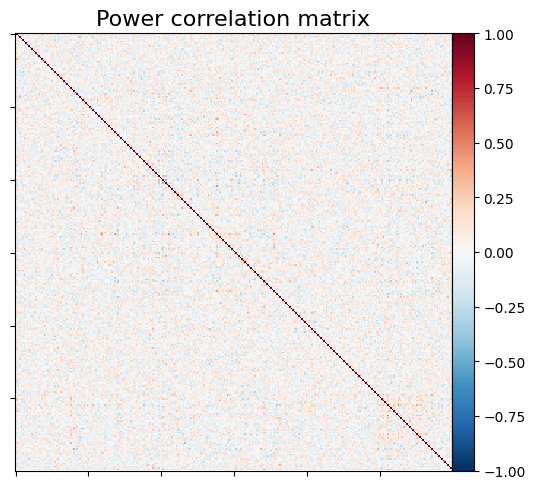

In [ ]:
spheres_masker = NiftiSpheresMasker(
    seeds=coords,
    smoothing_fwhm=3,
    radius=1.0,
    detrend=True,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    t_r=None#5*60,
)


sample_row = bp_data.iloc[0]  # Change the index (0) to the desired sample

data_path = sample_row['data']
confounds_data = sample_row['confounds']

# Perform preprocessing on confounds_data if needed
confounds_data = confounds_data.replace([np.nan, np.inf, -np.inf], 0)
timeseries = spheres_masker.fit_transform(data_path, confounds=confounds_data)

scaler = StandardScaler()

# Apply Z-score normalization to your time series data
timeseries_normalized = scaler.fit_transform(timeseries)

correlation_matrix = np.corrcoef(timeseries_normalized, rowvar=False)

# CONNECTOME MATRIX PLOTTING
plotting.plot_matrix(
    correlation_matrix,
    vmin=-1.0,
    vmax=1.0,
    colorbar=True,
    title="Power correlation matrix",
)

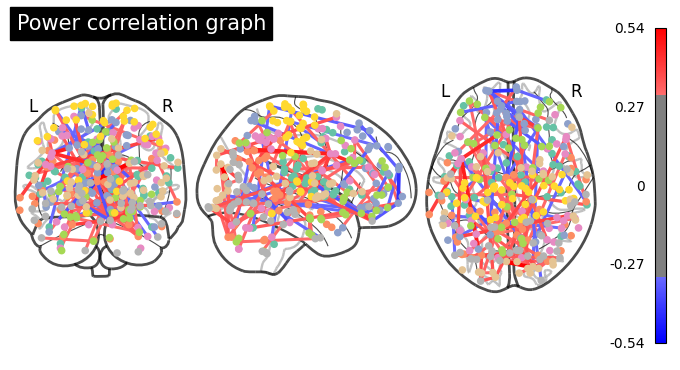

In [ ]:
# CONNECTOME PLOTTING
display =plotting.plot_connectome(
    correlation_matrix,
    coords,
    title="Power correlation graph",
    edge_threshold="99.8%",
    node_size=20,
    colorbar=True,
)

In [ ]:
power_correlation_matrix = correlation_matrix
G = nx.Graph()
n = power_correlation_matrix.shape[0]  # Number of brain regions

n = power_correlation_matrix.shape[0]
mask = ~np.eye(n, dtype=bool)

# Calculate the threshold based on the top 0.2% of values, excluding the diagonal
# Flatten the correlation matrix, excluding the diagonal
values = power_correlation_matrix[mask].flatten()

# Sort the values in descending order
sorted_values = np.sort(values)[::-1]

# Calculate the threshold
top_percentage = 0.5
threshold_idx = int(len(sorted_values) * top_percentage / 100)
threshold = sorted_values[threshold_idx]

for i in range(len(correlation_matrix)):
    for j in range(i + 1, len(correlation_matrix)):
        if abs(correlation_matrix[i, j]) >= threshold:
            G.add_edge(i, j)



In [ ]:
G = schz_data.at[1, 'graph']

cliques = nx.find_cliques(G)

In [ ]:
f= 0
for c in cliques:
  f+=1
f

264

In [ ]:
max(len(c) for c in nx.find_cliques(G))

5

In [ ]:
G = control_data.at[9, 'graph']

pos = nx.spring_layout(G)
node_degrees = dict(G.degree())


# Create a Plotly figure
fig = go.Figure()

# Add nodes to the figure with size proportional to degree
for node, (x, y) in pos.items():
    fig.add_trace(go.Scatter(x=[x], y=[y], mode="markers", marker=dict(size=2 * node_degrees[node], opacity=0.7), name=str(node_degrees[node])))

# Add edges to the figure
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
fig.add_trace(go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(width=1)))

# Customize the figure further as needed

# Show the interactive plot
fig.show()


In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
average_degree = sum(node_degrees.values()) / num_nodes

# Print the results
print("Number of Nodes:", num_nodes)
print("Number of Edges:", num_edges)
print("Average Degree:", average_degree)

Number of Nodes: 216
Number of Edges: 337
Average Degree: 3.1203703703703702


## Metrics test

In [ ]:
def process_graph_centralities(G):
    num_nodes = G.number_of_nodes()

    closeness = nx.closeness_centrality(G)

    betweenness = nx.betweenness_centrality(G)

    m_degree = sum((dict(G.degree())).values())/num_nodes
    m_closeness = sum(closeness.values())/num_nodes
    m_betweenness = sum(betweenness.values())/num_nodes
    avg_clust = nx.average_clustering(G)

    return m_closeness, m_betweenness, m_degree, avg_clust

def process_graphs(dataframe, condition):
    results = []
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        G = row['graph']
        m_closeness, m_betweenness, m_degree, avg_clust = process_graph_centralities(G)
        results.append((row.name, m_closeness, m_betweenness, m_degree, avg_clust))
    return results

In [39]:
# Wrapper for the dataframes
dataframes = [control_data, schz_data, bp_data, adhd_data]
conditions = ["Control", "Schizophrenia", "Bipolar", "ADHD"]
num_processes = multiprocessing.cpu_count()  # Number of available CPU cores

# Execution
with Pool(processes=num_processes) as pool:
    processed_data = pool.starmap(
        process_graphs,
        [(dataframe, condition) for dataframe, condition in zip(dataframes, conditions)]
    )

for df, results in zip(dataframes, processed_data):
    for result in results:
        row_name, m_closeness, m_betweenness, m_degree, avg_clust = result
        df.at[row_name, 'closeness'] = m_closeness
        df.at[row_name, 'betweenness'] = m_betweenness
        df.at[row_name, 'degree'] = m_degree
        df.at[row_name, 'clustering'] = avg_clust

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


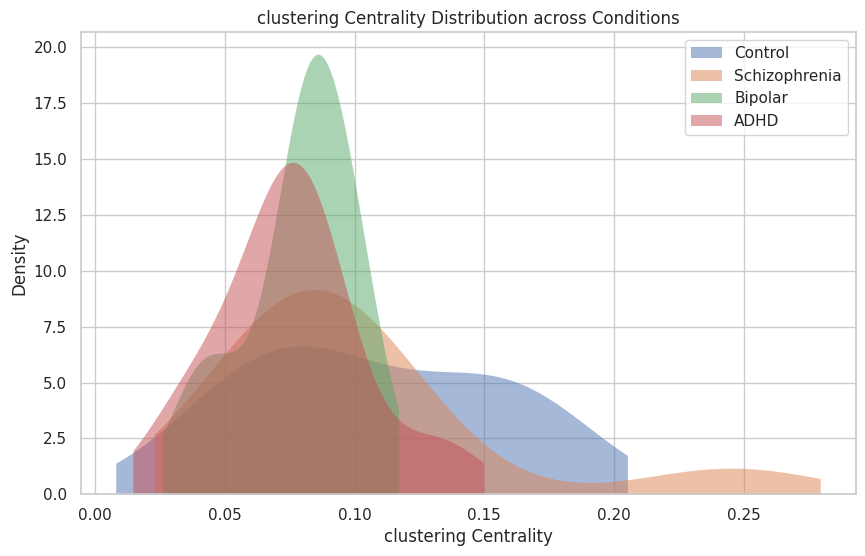

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style
sns.set(style="whitegrid")

# Plotting distributions with KDE and best-fit line
plt.figure(figsize=(10, 6))

# Control
sns.kdeplot(control_data['clustering'], label='Control', fill=True, common_norm=True, cut = 1,
   alpha=.5, linewidth=0,)

# Schizophrenia
sns.kdeplot(schz_data['clustering'], label='Schizophrenia', fill=True, common_norm=True, cut = 1,
   alpha=.5, linewidth=0,)

# Bipolar
sns.kdeplot(bp_data['clustering'], label='Bipolar', fill=True, common_norm=True, cut = 1,
   alpha=.5, linewidth=0,)

# ADHD
sns.kdeplot(adhd_data['clustering'], label='ADHD', fill=True, common_norm=True, cut = 1,
   alpha=.5, linewidth=0,)

# Adding labels and title
plt.xlabel('clustering Centrality')
plt.ylabel('Density')
plt.title('clustering Centrality Distribution across Conditions')

# Adding legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
print("Control:", control_data['betweenness'])
print("Schz:", schz_data['betweenness'])
print("Bi:", bp_data['betweenness'])
print("adhd:", adhd_data['betweenness'])

Control: 0    0.013017
1    0.015950
2    0.016366
3    0.019835
4    0.015782
5    0.017786
6    0.019532
7    0.016052
8    0.018941
9    0.013017
Name: betweenness, dtype: float64
Schz: 0    0.014257
1    0.018376
2    0.013379
3    0.015993
4    0.017484
5    0.017212
6    0.026320
7    0.017311
8    0.015905
9    0.016712
Name: betweenness, dtype: float64
Bi: 0    0.016805
1    0.015831
2    0.017002
3    0.019465
4    0.014110
5    0.015067
6    0.018381
7    0.019009
8    0.018034
9    0.012990
Name: betweenness, dtype: float64
adhd: 0    0.014623
1    0.017519
2    0.015785
3    0.016742
4    0.014851
5    0.017954
6    0.017294
7    0.017071
8    0.014986
9    0.015202
Name: betweenness, dtype: float64


#Save, upload zone

In [ ]:
#@title Save dataframes as csv?
save_data = True # @param {type:"boolean"}
if save_data:
      import pickle

      # Save dataframes with graphs using Pickle
      with open('/content/control_data.pkl', 'wb') as file:
          pickle.dump(control_data, file)

      with open('/content/schz_data.pkl', 'wb') as file:
          pickle.dump(schz_data, file)

      with open('/content/bp_data.pkl', 'wb') as file:
          pickle.dump(bp_data, file)

      with open('/content/adhd_data.pkl', 'wb') as file:
          pickle.dump(adhd_data, file)
      print('Dataframes saved!')

download_data = True # @param {type:"boolean"}
if download_data:
  from google.colab import files
  zip_file = '/content/dataframes.zip'
  !zip -r dataframes.zip /content/control_data.pkl /content/schz_data.pkl /content/bp_data.pkl /content/adhd_data.pkl
  files.download(zip_file)

Dataframes saved!
  adding: content/control_data.pkl (deflated 17%)
  adding: content/schz_data.pkl (deflated 17%)
  adding: content/bp_data.pkl (deflated 18%)
  adding: content/adhd_data.pkl (deflated 17%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Use precomputed

prec = True # @param {type:"boolean"}
if prec:
  import pickle
  # Load dataframes with graphs using Pickle
  with open('/content/control_data.pkl', 'rb') as file:
      control_data = pickle.load(file)

  with open('/content/schz_data.pkl', 'rb') as file:
      schz_data = pickle.load(file)

  with open('/content/bp_data.pkl', 'rb') as file:
      bp_data = pickle.load(file)

  with open('/content/adhd_data.pkl', 'rb') as file:
      adhd_data = pickle.load(file)

